**Pump it Up: Data Mining Competition**

**Team: WatrPt**

**Members: Ho Jun Cong Keith (A0184106L), Patt Wei Xuan, Elgin (A0183601M)**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset
from torch.utils.data.dataloader import DataLoader
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import FeatureUnion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


# Importing the Data

In [2]:
url = 'https://raw.githubusercontent.com/keithhjc/IS4242-Project-WatrPt/main/Training%20Set%20Labels.csv?token=AMBVJ2AWO5FQJ7SIXFATVOS7SPYW6'

Y_train = pd.read_csv(url)
Y_train.head(5)

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [3]:
url = 'https://raw.githubusercontent.com/keithhjc/IS4242-Project-WatrPt/main/Training%20Set%20Values.csv?token=AMBVJ2GQ6BY5G3A4MYIAXE27SPYUG'

X_train = pd.read_csv(url)
X_train.head(3)
X_train.shape

(59400, 40)

In [4]:
url = 'https://raw.githubusercontent.com/keithhjc/IS4242-Project-WatrPt/main/Test%20Set%20Values.csv'

X_test = pd.read_csv(url)
X_test.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other


By calling info on the dataset, we can visualise and categorize the variables into categorical and numerical variables.

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

Through a seaborn countplot, we observe that the dataset has quite an even number of functional and non functional data, but there is a lack of data for the functional needs repair category

Text(0.5, 1.0, 'Count of Functional / Non-functional pumps')

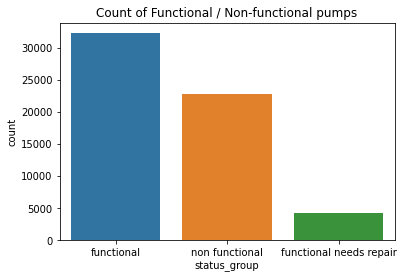

In [6]:
# Visualizing the functional components
sns.countplot(data = Y_train, x="status_group")
plt.title("Count of Functional / Non-functional pumps")

We append the functional status from Y_test onto X_test to allow us to visualise how individual data categories in a vaccum affect the status group distribution.

We can then use this to create pivot tables to better visualise our dataset

In [7]:
full_set = pd.concat([X_train, Y_train.status_group], axis=1, copy=False)
full_set.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional


By plotting pivot tables for the functional components, we are able to visualize the different distributions of pump functionality split across different values in the same category. 

This allows us to visualise and roughly estimate how status group distribution is spread over different values of a category.

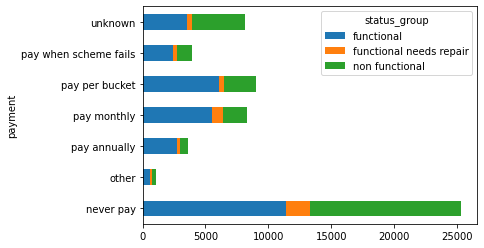

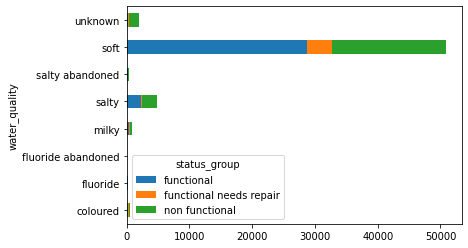

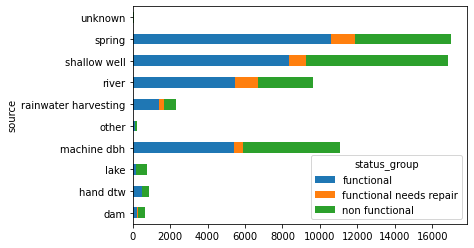

In [8]:
# Visualizing the functional components
pivot_payment = pd.pivot_table(full_set,index=['payment'], columns=['status_group'], aggfunc='count', dropna=True, values='id')
pivot_payment.plot(kind='barh', stacked='true')

pivot_water_quality = pd.pivot_table(full_set,index=['water_quality'], columns=['status_group'], aggfunc='count', dropna=True, values='id')
pivot_water_quality.plot(kind='barh', stacked='true')

pivot_source = pd.pivot_table(full_set,index=['source'], columns=['status_group'], aggfunc='count', dropna=True, values='id')
pivot_source.plot(kind='barh', stacked='true')

In [9]:
col_labels = list(X_train.columns)

# Preprocessing our data

As there are many processing to be done to the dataset, we will be using pipeline to make it easier to transform our test set later on.

In the first step of preprocessing, we first seperate the data into numerical and categorical features. For the two different kind of features, we would process it differently. 

Numerical Features:
For numerical features, we would first use simple imputation to fill missing or 0 values where appropriate. For example, 

In [10]:
numerics = ['int64', 'float64', 'int8']
num_var = list(X_train.select_dtypes(include=numerics).columns)
cat_var = list(set(X_train.columns)-set(num_var))
print("Numerical Variables:", num_var)
print("Categorical Variables:", cat_var)

Numerical Variables: ['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']
Categorical Variables: ['subvillage', 'funder', 'wpt_name', 'payment', 'quantity', 'source', 'installer', 'basin', 'extraction_type', 'ward', 'source_type', 'lga', 'payment_type', 'quantity_group', 'water_quality', 'source_class', 'management', 'region', 'management_group', 'waterpoint_type', 'extraction_type_class', 'date_recorded', 'public_meeting', 'scheme_name', 'scheme_management', 'recorded_by', 'permit', 'quality_group', 'extraction_type_group', 'waterpoint_type_group']


We then proceed to check the numerical values for any NaN values. From this we can see that there are no NaN values for numerical variables. However, we still need to check the dataset to confirm that null values are not represented by another number like 0.

In [11]:
X_train[num_var].isna().sum()

id                   0
amount_tsh           0
gps_height           0
longitude            0
latitude             0
num_private          0
region_code          0
district_code        0
population           0
construction_year    0
dtype: int64

After checking for null values, we proceed to check for 0 values, which seem to represent null values for this dataset for some categories. 

However, we cannot conclude that these 0 values are null for all of these categories deterministically. While some categories like year we can assume that 0 represents a null value, the value 0 for other categories like gps_height and population may be a valid value.

In [12]:
X_train[num_var].apply(lambda x: (x==0).sum())

id                       1
amount_tsh           41639
gps_height           20438
longitude             1812
latitude                 0
num_private          58643
region_code              0
district_code           23
population           21381
construction_year    20709
dtype: int64

Now that we know 0 is the null value for construction_year, we can visualize how the construction year affects the functionality of the pump. 

From this pivot table we can roughly visualise that pumps built later have a higher possibility of being functional compared to older pumps, which is semi-expected since they are newer.

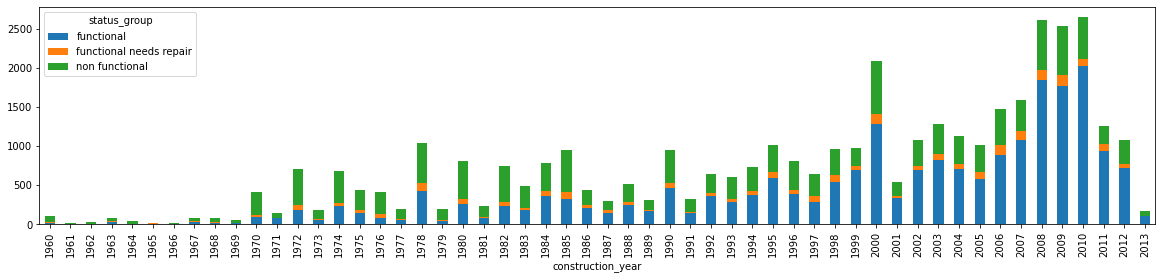

In [13]:
#full_set['construction_year'] = full_set['construction_year'].replace([0], np.NaN, inplace=True)

pivot_construction_year = pd.pivot_table(full_set,index=['construction_year'], columns=['status_group'], aggfunc='count', dropna=True, values='id')
pivot_construction_year = pivot_construction_year.drop([0])
pivot_construction_year.plot(kind='bar', stacked='true', figsize=(20,4))


Since we are unable to just perform imputation on construction year as it will skew the data, we will first perform a transformation on construction year to change it from a numerical value to a categorical feature. i.e to the form below:
*   1960 <= x < 1970
*   1970 <= x < 1980
*   1980 <= x < 1990
*   1990 <= x < 2000
*   2000 <= x < 2010
*   2010 <= x



In [14]:
# return third character of year plus 0s. 1960 -> 60s, 1970-> 70s, etc.
def construction_converter(row):
      if row == 0:
          return 'unknown'
      else:
          return str(row)[2] + '0s'

class ConstructionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self): # r specifies how many features to be eliminated. Higher r = more features dropped. E.g. r= 0.7 means in a data of 59400 rows, features with more than 41580 '0' values will be dropped.
        self.include = 'construction_year'
     
    def fit(self, X, y = None):
        return self 
    
    def transform(self, X, y = None):
        X['construction_year'] = X['construction_year'].apply(lambda row: construction_converter(row))
        return X

In [15]:
ctfs = ConstructionTransformer()
attt = ctfs.fit_transform(X_train[['construction_year']])
attt.value_counts()

construction_year
unknown              20709
00s                  15330
90s                   7678
80s                   5578
10s                   5161
70s                   4406
60s                    538
dtype: int64

In [16]:
# Updating the list of numerical and categorical variables
num_var.remove('construction_year')
cat_var.append('construction_year')

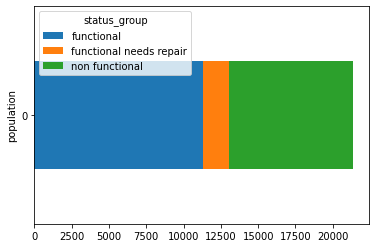

In [17]:
full_set_zero_pop = full_set[full_set.population.eq(0)]

pivot_zero_pop = pd.pivot_table(full_set_zero_pop,index=['population'], columns=['status_group'], aggfunc='count', dropna=True, values='id')
pivot_zero_pop.plot(kind='barh', stacked='true')

Since the data is collected from the same region of Tanzania, it is likely that the collected data is around the same longitude and latitude. 

As we can see from the box plot below, the longitude of the dataset is roughly within the same region, and thus taking the mean of these values to fill in null values (represented as 0) should not affect the model too much.


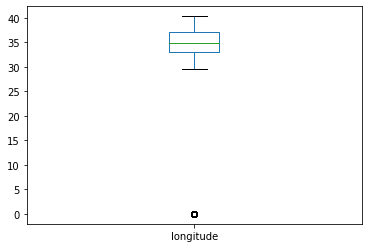

In [18]:
X_train['longitude'].plot.box()

We first fill in any missing longitude and latitude values by taking the mean of the other longitude and latitude values within the same region.

In [19]:
X_train['longitude'].replace(0, np.NaN, inplace=True)
X_train['longitude'] = X_train['longitude'].fillna(X_train.groupby('region_code')['longitude'].transform('mean'))

# Numerical Data Processing



Numerical Eliminator
---

We then use a numeric eliminator transformer in 
order to drop data columns that have more than r*100% of null values

Also, we would not need the ID column of the data as it does not affect our model. Hence, we can proceed to drop the ID column.

In [20]:
class NumElim(BaseEstimator, TransformerMixin):
    def __init__(self, r=0.5): # r specifies how many features to be eliminated. Higher r = more features dropped. E.g. r= 0.7 means in a data of 59400 rows, features with more than 41580 '0' values will be dropped.
        self.exclude = ['id']
        self.r = r
     
    def fit(self, X, y = None):
        n = len(X)
        # cts = count(X>) TO BE EDITED TO COUNT NUMBER OF 0 VALUES INSTEAD
        cts = X.apply(lambda x: (x==0).sum())
        cts = n - cts
        self.exclude.extend(cts.index[cts < (self.r * n)].tolist())
        return self 
    
    def transform(self, X, y = None):
        return X.drop(self.exclude, errors='ignore', axis=1)

By varying the r value, we can eliminate data columns with different percentages of null values to improve model accuracy

In [21]:
# # For Testing purposes
# num_elim = NumElim(r=0.5)
# X_num1 = se.fit_transform(X_train[num_var])
# X_num1


Numerical Preprocessor
---


By grouping the data by region, we are able to get the means for longitude and latitude per region.

This gives us values to fill in null values for longitude and latitude, as long as the row of data has a valid region.

In [22]:
class Num_Preprocessor(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.exclude = ['amount_tsh', 'gps_height']
    self.toProcess = ['longitude']

  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X_new = X.copy()
    for col in X_new:
      if (col not in self.exclude):
        X_new[col].replace(0, np.NaN, inplace = True)
    if (self.toProcess[0] in X_new.columns):
      X_new[self.toProcess[0]] = X_new[self.toProcess[0]].fillna(X_new.groupby('region_code')['longitude'].transform('mean'))
    return X_new

In [23]:
# # For Testing Purposes
# numpre = Num_Preprocessor()
# X_num2 = numpre.fit_transform(X_train[num_var])
# X_num2.head(3)


Numerical Transformer
---


For the rest of the numerical values, we use a SimpleImputer to fill in NaN values with the most_frequent strategy in order to eliminate null values.

We then build a pipeline of the numerical eliminator which eliminates columns with too many null values, the preprocessor for longitude and latitude, and the imputer metioned above.

In [24]:
num_imp = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')

num_transformer = Pipeline(steps = [('num_elim', NumElim(r = 0.5)),
                                    ('num_process', Num_Preprocessor()),
                                    ('num_imp', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

In [25]:
# # FOR TESTING PURPOSES
X_num3 = num_transformer.fit_transform(X_train[num_var])
X_num3 = pd.DataFrame(X_num3, columns = ['gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population'])
X_num3

,gps_height,longitude,latitude,region_code,district_code,population
0,1390.0,34.938093,-9.856322,11.0,5.0,109.0
1,1399.0,34.698766,-2.147466,20.0,2.0,280.0
2,686.0,37.460664,-3.821329,21.0,4.0,250.0
3,263.0,38.486161,-11.155298,90.0,63.0,58.0
4,0.0,31.130847,-1.825359,18.0,1.0,1.0
...,...,...,...,...,...,...
59395,1210.0,37.169807,-3.253847,3.0,5.0,125.0
59396,1212.0,35.249991,-9.070629,11.0,4.0,56.0
59397,0.0,34.017087,-8.750434,12.0,7.0,1.0
59398,0.0,35.861315,-6.378573,1.0,4.0,1.0


# Categorical Data Processing

##Specifying Columns to Drop

After processing the numerical data, we now take a look at the categorical data.

We first check the number of unique values per column of data to identify categorical columns with a high number of unique values to eliminate from the dataset as a high amount of unique values may not be able to contribute to the model conclusively.

We check the unique values of the data for both the test and train dataset to determine if there are any columns we have to take note of that differ in unique values.

In [26]:
X_test[cat_var].apply(lambda x: x.nunique())

subvillage                8443
funder                     980
wpt_name                 10840
payment                      7
quantity                     5
source                      10
installer                 1091
basin                        9
extraction_type             17
ward                      1959
source_type                  7
lga                        125
payment_type                 7
quantity_group               5
water_quality                8
source_class                 3
management                  12
region                      21
management_group             5
waterpoint_type              7
extraction_type_class        7
date_recorded              331
public_meeting               2
scheme_name               1789
scheme_management           11
recorded_by                  1
permit                       2
quality_group                6
extraction_type_group       13
waterpoint_type_group        6
construction_year           55
dtype: int64

In [27]:
X_train[cat_var].apply(lambda x: x.nunique())

subvillage               19287
funder                    1897
wpt_name                 37400
payment                      7
quantity                     5
source                      10
installer                 2145
basin                        9
extraction_type             18
ward                      2092
source_type                  7
lga                        125
payment_type                 7
quantity_group               5
water_quality                8
source_class                 3
management                  12
region                      21
management_group             5
waterpoint_type              7
extraction_type_class        7
date_recorded              356
public_meeting               2
scheme_name               2696
scheme_management           12
recorded_by                  1
permit                       2
quality_group                6
extraction_type_group       13
waterpoint_type_group        6
construction_year           55
dtype: int64

For some categorical data, null values are present in the data. An example is shown below for public_meeting.

We can see that the numbers do not add up to 59400.

In [28]:
X_train.public_meeting.value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

Running through the categorical dataset, we see that there are several columns with almost entirely the same data. These columns seems to be capturing the same related set of data. We first compute the similarities between 2 of such columns using a simple function as shown below.

In [29]:
diff = (X_train['quantity']!=X_train['quantity_group']).sum()/len(X_train['quantity'])
print("% Difference between quantity and quantity group :", diff)

diff = (X_train['extraction_type']!=X_train['extraction_type_group']).sum()/len(X_train['extraction_type'])
print("% Difference between extraction_type and extraction_type_group :", diff)

diff = (X_train['extraction_type']!=X_train['extraction_type_class']).sum()/len(X_train['extraction_type'])
print("% Difference between extraction_type and extraction_type_class :", diff)

diff = (X_train['payment']!=X_train['payment_type']).sum()/len(X_train['payment'])
print("% Difference between payment and payment_type :", diff)

diff = (X_train['source']!=X_train['source_type']).sum()/len(X_train['source'])
print("% Difference between source and source_type :", diff)

diff = (X_train['waterpoint_type']!=X_train['waterpoint_type_group']).sum()/len(X_train['waterpoint_type'])
print("% Difference between waterpoint and waterpoint_type :", diff)

diff = (X_train['water_quality']!=X_train['quality_group']).sum()/len(X_train['water_quality'])
print("% Difference between water_quality and quality_group :", diff)

diff = (X_train['management']!=X_train['management_group']).sum()/len(X_train['management'])
print("% Difference between management and management_group :", diff)



% Difference between quantity and quantity group : 0.0
% Difference between extraction_type and extraction_type_group : 0.04156565656565656
% Difference between extraction_type and extraction_type_class : 0.3607070707070707
% Difference between payment and payment_type : 0.4181986531986532
% Difference between source and source_type : 0.37696969696969695
% Difference between waterpoint and waterpoint_type : 0.10274410774410775
% Difference between water_quality and quality_group : 0.8697643097643097
% Difference between management and management_group : 0.9465824915824916


In the analysis above, we see that there are significant differences between data such as payment and payment_type, source and source_type. However, diving further into the data, we find that one column is a more elaborate version of the other. For example, payment provides more information than payment_type. Source provides more information than source_type.

To prove this, we run a simple experiment as shown below.

In [30]:
print("Original payment values:", X_train['payment'].unique())
print("Original payment_type values:", X_train['payment_type'].unique())

payment_temp = X_train['payment'].replace('pay annually', 'annually')
payment_temp.replace('pay per bucket', 'per bucket', inplace=True)
payment_temp.replace('pay when scheme fails', 'on failure', inplace=True)
payment_temp.replace('pay monthly', 'monthly', inplace=True)

diff = (payment_temp!=X_train['payment_type']).sum()/len(payment_temp)
print("% Difference between payment and payment_type :", diff)

Original payment values: ['pay annually' 'never pay' 'pay per bucket' 'unknown'
 'pay when scheme fails' 'other' 'pay monthly']
Original payment_type values: ['annually' 'never pay' 'per bucket' 'unknown' 'on failure' 'other'
 'monthly']
% Difference between payment and payment_type : 0.0


In [31]:
print("Original source values:", X_train['source'].unique())
print("Original source_type values:", X_train['source_type'].unique())

source_temp = X_train['source'].replace('machine dbh', 'borehole')
source_temp.replace(dict.fromkeys(['river', 'lake'], 'river/lake'), inplace=True)
print("Converted source values:", source_temp.unique())

diff = (source_temp!=X_train['source_type']).sum()/len(source_temp)
print("% Difference between source and source_type :", diff)

Original source values: ['spring' 'rainwater harvesting' 'dam' 'machine dbh' 'other'
 'shallow well' 'river' 'hand dtw' 'lake' 'unknown']
Original source_type values: ['spring' 'rainwater harvesting' 'dam' 'borehole' 'other' 'shallow well'
 'river/lake']
Converted source values: ['spring' 'rainwater harvesting' 'dam' 'borehole' 'other' 'shallow well'
 'river/lake' 'hand dtw' 'unknown']
% Difference between source and source_type : 0.015824915824915825


As can be seen from the examples above, after replacing values from payment and source, we are able to minimize the differences to 0 and 0.02 respectively. In fact, the 0.02 differences lies in additional information provided in source that is not included in source_type - ['hand dtw', 'unknown']. 
As a result, we conclude that there is minimal loss of data by excluding all the '_type' columns. We will proceed to remove these columns from our dataset.

In [32]:
# print("Original water_quality values:", X_train['water_quality'].unique())
# print("Original quality_group values:", X_train['quality_group'].unique())
water_temp = X_train['water_quality'].replace('soft', 'good')
water_temp.replace('salty abandoned', 'salty', inplace=True)

diff = (water_temp!=X_train['quality_group']).sum()/len(water_temp)
print("% Difference between water_quality and quality_group :", diff)
print("\n")

# print("Original management values:", X_train['management'].unique())
# print("Original management_group values:", X_train['management_group'].unique())
# From the dataset, can see that vwc, wug, wua and waterboards all fall under user-groups. Similarly, water authority, company, private operator are commercial
management_temp = X_train['management'].replace(dict.fromkeys(['vwc', 'wug', 'wua', 'water board'], 'user-group'))
management_temp.replace(dict.fromkeys(['water authority', 'private operator', 'company'], 'commercial'), inplace=True)

diff = (management_temp!=X_train['management_group']).sum()/len(management_temp)
print("% Difference between management and management_group :", diff)

% Difference between water_quality and quality_group : 0.008535353535353535


% Difference between management and management_group : 0.00297979797979798


From the above example, we can observe that water_quality is related to quality_group, and management is related to management_group. In other words, we are able to derive managment_group from management.

In [33]:
X_train['recorded_by'].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

Since the data is fully recorded by "GeoData Consultants Ltd', this column is completely redundant for the model. As a result, this column shall be omitted as well.

In [34]:
excluded = ['extraction_type_group', 'extraction_type_class', 'payment_type', 'quantity_group', 'source_type', 'waterpoint_type_group', 'recorded_by', 'management_group', 'quality_group']


Categorical Eliminator
---


Next, we use a category eliminator to drop categorical columns with more than a specific number of values, specified here as limit

In [35]:
class CategoryElim(BaseEstimator, TransformerMixin):
    def __init__(self, limit = 2000):
        self.exclude = ['extraction_type_group', 'extraction_type_class', 'payment_type', 'quantity_group', 'source_type', 'waterpoint_type_group', 'recorded_by', 'management_group', 'quality_group']
        self.limit = limit

    def fit(self, X, y = None):
        unique = X.nunique()
        # To dynamically drop columns with more than a certain number of unique values
        self.exclude.extend(list(pd.DataFrame(unique[unique>self.limit]).index))
        return self
    
    def transform(self, X, y = None):
        return X.drop(self.exclude, errors='ignore', axis=1)

We can see that after running the original dataset through the eliminator, there are a few columns that had a lot of different unique values that were eliminated.

All remaining columns would then be more relevant to the model since with too many unique categories the data might affect model accuracy.

In [36]:
# # For Testing Purposes
cat_elim = CategoryElim()
X_cat1 = cat_elim.fit_transform(X_train[cat_var])
X_cat1

,funder,payment,quantity,source,basin,extraction_type,lga,water_quality,source_class,management,region,waterpoint_type,date_recorded,public_meeting,scheme_management,permit,construction_year
0,Roman,pay annually,enough,spring,Lake Nyasa,gravity,Ludewa,soft,groundwater,vwc,Iringa,communal standpipe,2011-03-14,True,VWC,False,1999
1,Grumeti,never pay,insufficient,rainwater harvesting,Lake Victoria,gravity,Serengeti,soft,surface,wug,Mara,communal standpipe,2013-03-06,NaN,Other,True,2010
2,Lottery Club,pay per bucket,enough,dam,Pangani,gravity,Simanjiro,soft,surface,vwc,Manyara,communal standpipe multiple,2013-02-25,True,VWC,True,2009
3,Unicef,never pay,dry,machine dbh,Ruvuma / Southern Coast,submersible,Nanyumbu,soft,groundwater,vwc,Mtwara,communal standpipe multiple,2013-01-28,True,VWC,True,1986
4,Action In A,never pay,seasonal,rainwater harvesting,Lake Victoria,gravity,Karagwe,soft,surface,other,Kagera,communal standpipe,2011-07-13,True,NaN,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,Germany Republi,pay per bucket,enough,spring,Pangani,gravity,Hai,soft,groundwater,water board,Kilimanjaro,communal standpipe,2013-05-03,True,Water Board,True,1999
59396,Cefa-njombe,pay annually,enough,river,Rufiji,gravity,Njombe,soft,surface,vwc,Iringa,communal standpipe,2011-05-07,True,VWC,True,1996
59397,NaN,pay monthly,enough,machine dbh,Rufiji,swn 80,Mbarali,fluoride,groundwater,vwc,Mbeya,hand pump,2011-04-11,True,VWC,False,0
59398,Malec,never pay,insufficient,shallow well,Rufiji,nira/tanira,Chamwino,soft,groundwater,vwc,Dodoma,hand pump,2011-03-08,True,VWC,True,0



Categorical Preprocessor
---


Our first Categorical Preprocessor simply transform several categorical values into numerical values. 
* Firstly date will be extracted from a datetime format to just the month and year.  For e.g. (28/11/2010) -> 11 and 2010.
* Permit which is true/false will be label encoded to become 0s and 1s.
* Public meeting is made up of true/false values as well. However, there are many empty values that we are not able to fill. Therefore, we will convert it to true, false or unknown to perform one-hot encoding later.

In [37]:
# Convert true/false to binary and date to numerical data
class Cat_Preprocessor1(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.toConvert = ['date_recorded', 'permit', 'public_meeting']
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_new = X.copy()
        for col in X_new.columns:
          if(col == self.toConvert[0]):
              # Convert date_recorded into numerical columns of year and month
              X_new['year_recorded'] = X_new[col].apply(lambda x: int(x.split('-')[0]))
              X_new['month_recorded'] = X_new[col].apply(lambda x: int(x.split('-')[1]))
              X_new.drop([self.toConvert[0]], axis =1, inplace=True)
          elif(col == self.toConvert[1]):
            # Convert permit into a binary variable (true/false)
            X_new['permit'] = X_new['permit'].astype('category')
            X_new['permit'] = X_new['permit'].cat.codes
            pd.to_numeric(X_new['permit'])

          # Decided to leave public_meeting as True/False because of missing values
          elif(col == self.toConvert[2]):
            # Convert public meeting into a binary variable (true/false)
            # X_new['public_meeting'] = X_new['public_meeting'].astype('category')
            # X_new['public_meeting'] = X_new['public_meeting'].cat.codes
            X_new['public_meeting'].replace(np.nan, 'unknown', inplace=True)
            X_new['public_meeting'] = X_new['public_meeting'].astype('str')
        return X_new

We test our preprocessor to make sure that the data comes out the way we require it to be.

In [38]:
# # For Testing Purposes
cat_proc1 = Cat_Preprocessor1()
X_cat2 = cat_proc1.fit_transform(X_cat1)
X_cat2

# Note that there is one additional column after Cat_Preprocessor1 as date recorded is split into month and year.

,funder,payment,quantity,source,basin,extraction_type,lga,water_quality,source_class,management,region,waterpoint_type,public_meeting,scheme_management,permit,construction_year,year_recorded,month_recorded
0,Roman,pay annually,enough,spring,Lake Nyasa,gravity,Ludewa,soft,groundwater,vwc,Iringa,communal standpipe,True,VWC,0,1999,2011,3
1,Grumeti,never pay,insufficient,rainwater harvesting,Lake Victoria,gravity,Serengeti,soft,surface,wug,Mara,communal standpipe,unknown,Other,1,2010,2013,3
2,Lottery Club,pay per bucket,enough,dam,Pangani,gravity,Simanjiro,soft,surface,vwc,Manyara,communal standpipe multiple,True,VWC,1,2009,2013,2
3,Unicef,never pay,dry,machine dbh,Ruvuma / Southern Coast,submersible,Nanyumbu,soft,groundwater,vwc,Mtwara,communal standpipe multiple,True,VWC,1,1986,2013,1
4,Action In A,never pay,seasonal,rainwater harvesting,Lake Victoria,gravity,Karagwe,soft,surface,other,Kagera,communal standpipe,True,NaN,1,0,2011,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,Germany Republi,pay per bucket,enough,spring,Pangani,gravity,Hai,soft,groundwater,water board,Kilimanjaro,communal standpipe,True,Water Board,1,1999,2013,5
59396,Cefa-njombe,pay annually,enough,river,Rufiji,gravity,Njombe,soft,surface,vwc,Iringa,communal standpipe,True,VWC,1,1996,2011,5
59397,NaN,pay monthly,enough,machine dbh,Rufiji,swn 80,Mbarali,fluoride,groundwater,vwc,Mbeya,hand pump,True,VWC,0,0,2011,4
59398,Malec,never pay,insufficient,shallow well,Rufiji,nira/tanira,Chamwino,soft,groundwater,vwc,Dodoma,hand pump,True,VWC,1,0,2011,3



We also have a second preprocessor for categorical data that deals with categories that have way too many different unique values.

This is to handle cases where there are a decent amount of unique values, but the number of entries for each value is significant enough to consider in the model.

For our preprocessor, we put an arbitrary value of 5 such that any values outside of the top 5 most common values for that category will get transformed as "Others".

For e.g. if funder had many unique values ['Government of Tanzania', 'Danida', 'Hesawa', 'Rwssp', 'World Bank', 'kkkt' ...],
Only the top 5 will be considered and the remanining values will be grouped as others.

In [39]:
def topXConversion(row, val_kept, colName):
  if row[colName] in val_kept:
    return row[colName]
  else:
    return 'other'

# topX refer to number of unique labels to be kept.
class Cat_Preprocessor2(BaseEstimator, TransformerMixin):
    def __init__(self, topX = 5):
        self.topX = topX
        self.rows = []

    def fit(self, X, y = None):
        for col in X:
          topRows = []
          # Return the value count of the column in a list format
          val_counts = list(X[col].value_counts().index)

          # Checks if original unique values are already less than topX
          if(len(val_counts) < self.topX):
            topRows.append(val_counts)

          else:
            # Extract names of top rows based on topX number 
            for i in range(self.topX):
              topRows.append(val_counts[i])
            # Tells self.rows which values to keep in a 2d matrix form.
          self.rows.append(topRows)
        return self
    

    # Restrict number of unique values such that small values will be grouped under others
    def transform(self, X, y = None):
        X_new = X.copy()
        # Loop through all the columns that was found in fit function earlier 
        for i in range(len(self.rows)):
          # val_kept describes all the rows that should be leftover after cutoff
          val_kept = self.rows[i]
          current_col = list(X_new.columns)[i]
          X_new[current_col] = X_new.apply(lambda row: topXConversion(row, val_kept, current_col), axis =1)
        
        return X_new

Once again, we test our second preprocessor to make sure that the data is being processed adequately

In [40]:
# # For Testing Purposes
cat_proc2 = Cat_Preprocessor2()
X_cat3 = cat_proc2.fit_transform(X_cat1)
X_cat3

,funder,payment,quantity,source,basin,extraction_type,lga,water_quality,source_class,management,region,waterpoint_type,date_recorded,public_meeting,scheme_management,permit,construction_year
0,other,other,enough,spring,other,gravity,other,soft,other,vwc,Iringa,communal standpipe,2011-03-14,other,VWC,other,other
1,other,never pay,insufficient,rainwater harvesting,Lake Victoria,gravity,other,soft,other,wug,other,communal standpipe,other,other,other,other,2010
2,other,pay per bucket,enough,other,Pangani,gravity,other,soft,other,vwc,other,communal standpipe multiple,other,other,VWC,other,2009
3,other,never pay,dry,machine dbh,other,submersible,other,soft,other,vwc,other,communal standpipe multiple,other,other,VWC,other,other
4,other,never pay,seasonal,rainwater harvesting,Lake Victoria,gravity,other,soft,other,other,other,communal standpipe,other,other,other,other,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,pay per bucket,enough,spring,Pangani,gravity,other,soft,other,water board,Kilimanjaro,communal standpipe,other,other,Water Board,other,other
59396,other,other,enough,river,Rufiji,gravity,Njombe,soft,other,vwc,Iringa,communal standpipe,other,other,VWC,other,other
59397,other,pay monthly,enough,machine dbh,Rufiji,swn 80,other,other,other,vwc,Mbeya,hand pump,other,other,VWC,other,0
59398,other,never pay,insufficient,shallow well,Rufiji,nira/tanira,other,soft,other,vwc,other,hand pump,other,other,VWC,other,0


As seem in the test dataset from running the code above, the preprocessor has transformed many of the values for categorical variables into others to reduce the number of unique variables.

In [41]:
X_cat3['basin'].value_counts()

other              18019
Lake Victoria      10248
Pangani             8940
Rufiji              7976
Internal            7785
Lake Tanganyika     6432
Name: basin, dtype: int64

For testing, we can see that basin is separated into the top 5 values and others. In this case, we can see that there is a disproportionate amount of 'other' in this dataset. This suggests that there are too many groups or independent values in 'basin'. 

As a good practice, we left topX as a hyperparameter so that we might try to increase the number of details later. However for now, we will stick to a value of 5.

Now, we write our one hot encoding class that looks for all of the non-numerical variables and encode them automatically.

In [42]:
# Manually constructed one hot encoding class
class OneHotEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.include = []
    def fit(self, X, y = None):
        X = pd.DataFrame(X)
        self.include.extend(list(X.select_dtypes(exclude=numerics).columns))
        return self
    
    def transform(self, X, y = None):
        X = pd.DataFrame(X)
        encoded = pd.get_dummies(X, columns=self.include)
        return encoded


Categorical Transformer
---



We write a simple transformer to convert arrays into a dataframe with column post ColumnTransformer transformation. This is to allow the data output by the first preprocessor to be processed by the second preprocessor, since the output of the first preprocessor is in array form, but the input required is a dataframe.

In [43]:
# Simple Transformer to convert array (after Column Transformer) into DataFrame with columns
class toDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.num = ['permit', 'year_recorded', 'month_recorded']
        self.all = ['permit', 'public_meeting', 'year_recorded', 'month_recorded', 'construction_year', 'management', 
                    'extraction_type', 'region', 'source', 'quantity', 'scheme_management', 'basin', 'waterpoint_type', 
                    'payment', 'funder', 'water_quality', 'source_class', 'lga']

    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_new = pd.DataFrame(X)
        X_new.columns = self.all
        X_new[self.num] = X_new[self.num].apply(pd.to_numeric)
        return X_new

We then group the features into the different categorical groups to be processed by different transformers.

We combine our two preprocessors with the intermediary transformer in between to chain the method calls and complete our categorical transformer.

In [44]:
 cat1_features = ['date_recorded', 'permit', 'public_meeting']
 cat2_features = ['management', 'extraction_type', 'region', 'source', 'quantity',
       'scheme_management', 'basin', 'waterpoint_type', 'payment', 'funder', 'water_quality',
       'source_class', 'lga']

cat_converter = ColumnTransformer(transformers= [('cat1_process', Cat_Preprocessor1(), cat1_features),
                                                 ('construction_trf', ConstructionTransformer(), ['construction_year']),
                                                 ('cat2_process', Cat_Preprocessor2(), cat2_features)])

cat_transformer = Pipeline(steps = [('cat_elim', CategoryElim()),
                                    ('cat_convert', cat_converter),
                                    ('to_df', toDataFrame()),
                                    ('ohe', OneHotEncoding())
                                    ])

In [45]:
# # For Testing Purposes
X_cat4 = cat_transformer.fit_transform(X_train[cat_var])
X_cat4

,permit,year_recorded,month_recorded,public_meeting_False,public_meeting_True,public_meeting_unknown,construction_year_00s,construction_year_10s,construction_year_60s,construction_year_70s,construction_year_80s,construction_year_90s,construction_year_unknown,management_other,management_private operator,management_vwc,management_water board,management_wua,management_wug,extraction_type_gravity,extraction_type_nira/tanira,extraction_type_other,extraction_type_submersible,extraction_type_swn 80,region_Iringa,region_Kilimanjaro,region_Mbeya,region_Morogoro,region_Shinyanga,region_other,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,...,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority,scheme_management_other,basin_Internal,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_other,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,payment_never pay,payment_other,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,funder_Danida,funder_Government Of Tanzania,funder_Hesawa,funder_Rwssp,funder_World Bank,funder_other,water_quality_coloured,water_quality_milky,water_quality_other,water_quality_salty,water_quality_soft,water_quality_unknown,source_class_other,lga_Arusha Rural,lga_Bariadi,lga_Moshi Rural,lga_Njombe,lga_Rungwe,lga_other
0,0,2011,3,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1
1,1,2013,3,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1
2,1,2013,2,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1
3,1,2013,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1
4,1,2011,7,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,1,2013,5,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1
59396,1,2011,5,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0
59397,0,2011,4,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1
59398,1,2011,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1


In [46]:
# # For Testing Purposes
X_cat_test = cat_transformer.transform(X_test[cat_var])
X_cat_test

,permit,year_recorded,month_recorded,public_meeting_False,public_meeting_True,public_meeting_unknown,construction_year_00s,construction_year_10s,construction_year_60s,construction_year_70s,construction_year_80s,construction_year_90s,construction_year_unknown,management_other,management_private operator,management_vwc,management_water board,management_wua,management_wug,extraction_type_gravity,extraction_type_nira/tanira,extraction_type_other,extraction_type_submersible,extraction_type_swn 80,region_Iringa,region_Kilimanjaro,region_Mbeya,region_Morogoro,region_Shinyanga,region_other,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,...,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority,scheme_management_other,basin_Internal,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_other,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,payment_never pay,payment_other,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,funder_Danida,funder_Government Of Tanzania,funder_Hesawa,funder_Rwssp,funder_World Bank,funder_other,water_quality_coloured,water_quality_milky,water_quality_other,water_quality_salty,water_quality_soft,water_quality_unknown,source_class_other,lga_Arusha Rural,lga_Bariadi,lga_Moshi Rural,lga_Njombe,lga_Rungwe,lga_other
0,1,2013,2,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1
1,1,2013,2,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0
2,-1,2013,2,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1
3,1,2013,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1
4,1,2013,3,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,1,2011,2,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
14846,0,2011,3,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
14847,-1,2013,3,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1
14848,1,2013,2,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1


# Generating the Processed Dataset

In [47]:
# To retrieve all the column labels to see data clearer in a dataframe format
num_final = list(X_num3.columns)
cat_final = list(X_cat4.columns)
col_final = num_final + cat_final

In [48]:
data_proc = ColumnTransformer(transformers=[('num', num_transformer, num_var),
                                            ('cat', cat_transformer, cat_var)])

X_train_proc = data_proc.fit_transform(X_train)
X_train_proc = pd.DataFrame(X_train_proc, columns=col_final)
X_train_proc

,gps_height,longitude,latitude,region_code,district_code,population,permit,year_recorded,month_recorded,public_meeting_False,public_meeting_True,public_meeting_unknown,construction_year_00s,construction_year_10s,construction_year_60s,construction_year_70s,construction_year_80s,construction_year_90s,construction_year_unknown,management_other,management_private operator,management_vwc,management_water board,management_wua,management_wug,extraction_type_gravity,extraction_type_nira/tanira,extraction_type_other,extraction_type_submersible,extraction_type_swn 80,region_Iringa,region_Kilimanjaro,region_Mbeya,region_Morogoro,region_Shinyanga,region_other,source_machine dbh,source_other,source_rainwater harvesting,source_river,...,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority,scheme_management_other,basin_Internal,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_other,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,payment_never pay,payment_other,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,funder_Danida,funder_Government Of Tanzania,funder_Hesawa,funder_Rwssp,funder_World Bank,funder_other,water_quality_coloured,water_quality_milky,water_quality_other,water_quality_salty,water_quality_soft,water_quality_unknown,source_class_other,lga_Arusha Rural,lga_Bariadi,lga_Moshi Rural,lga_Njombe,lga_Rungwe,lga_other
0,1390.0,34.938093,-9.856322,11.0,5.0,109.0,0.0,2011.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1399.0,34.698766,-2.147466,20.0,2.0,280.0,1.0,2013.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,686.0,37.460664,-3.821329,21.0,4.0,250.0,1.0,2013.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,263.0,38.486161,-11.155298,90.0,63.0,58.0,1.0,2013.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,31.130847,-1.825359,18.0,1.0,1.0,1.0,2011.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,1210.0,37.169807,-3.253847,3.0,5.0,125.0,1.0,2013.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
59396,1212.0,35.249991,-9.070629,11.0,4.0,56.0,1.0,2

This shall be the main data after the full processing that will be used in our model. For ease, PCA and Scaling will be left out of this dataset and will only be performed during model building in the next step.

# Model Building

To allow for the Y values to be trained and recognizable, we first label encode it. To do so,
we convert Y_train to type "category". This allows the data to be later coded into numerical format. 
> 0 : Functional

> 1 : Functional need Repair

> 2 : Non-Functional




In [49]:
Y_train.head(5)

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [50]:
Y_train_enc = Y_train['status_group'].astype('category')
Y_train_enc = Y_train_enc.cat.codes
Y_train_enc.head(5)

0    0
1    0
2    0
3    2
4    0
dtype: int8


K Neighbor Classification Model
---



### First submission with KNN classifier

In [51]:
# data_proc gives the complete dataset after preprocessing. 
knn_cls = Pipeline(steps=[('preprocess', data_proc),
                          ('scaler', StandardScaler()),
                          ('pca', PCA()),
                          ('knn', KNeighborsClassifier())])
hyparams = {'preprocess__num__num_elim__r': [0.5, 0.8],
            'pca__n_components': [20, 30, 40],
            'knn__n_neighbors': [3, 5, 7]}
model = GridSearchCV(knn_cls, hyparams, cv=5)
model.fit(X_train, Y_train_enc)

KeyboardInterrupt: ignored

In [ ]:
model.best_estimator_

In [ ]:
scores = cross_val_score(model.best_estimator_, X_train, Y_train_enc, cv=5)

In [ ]:
np.mean(scores)

In [ ]:
Y_pred = model.predict(X_test)

Getting data ready for submission...

In [ ]:
pred_Id = X_test['id']
pred_Id

In [ ]:
submit = pd.DataFrame(data=pred_Id, columns=['id'])
submit['status_group'] = Y_pred


In [ ]:
vals_to_replace = {0:'functional', 1:'functional needs repair',
                   2:'non functional'}

submit.status_group = submit.status_group.replace(vals_to_replace)
submit.head()

In [ ]:
submit.to_csv('knn_predictions.csv', index=False)

On our first submision of the K Neighbors Classification Model, we got a accuracy score of **0.7768**. To see what parameters are used for the model, we look at our model.best_estimator_ to see that the following parameters are being used:

*  Numerical Eliminator r value: 0.5
*  Simple Imputer Strategy: Most Frequent
*  PCA n_components: 30
*  KNN n_neighbors: 7




###Improving Our Model For Second Submission




Following the first submission, we try to improve our model by adding tuning more hyperparameters while fixing the other ones to reduce run time.
Specificially, we would like to experiment with keeping the features ['installer', 'ward'] in our dataset by increasing the category eliminator 'limit' value to 2500. 
We also try to retain more information in the categorical variables by increasing the hyperparameter 'topX' to 7 instead of 5. All these will be done at a cost of increasing runtime but might help us develop a more accurate model.

In [ ]:
# data_proc gives the complete dataset after preprocessing. 
knn_cls = Pipeline(steps=[('preprocess', data_proc),
                          ('scaler', StandardScaler()),
                          ('pca', PCA()),
                          ('knn', KNeighborsClassifier())])
hyparams = {'preprocess__num__num_elim__r': [0.5],  #fix numerical eliminator r since it works fine
            'preprocess__cat__cat_elim__limit': [2000, 2500],
            'preprocess__cat__cat_convert__cat2_process__topX': [5, 7],
            'pca__n_components': [30],   #fixed pca no.components at 30
            'knn__n_neighbors': [5, 7, 9]}
model2 = GridSearchCV(knn_cls, hyparams, cv=5)
model2.fit(X_train, Y_train_enc)

In [ ]:
model2.best_params_

Since the tuned model parameters did not change from the first model, we will keep the current tuning parameters for our model. Nothing will be changed. 


Neural Network Model
---



For our ANN model, we will be using the processed data that we generated earlier. We will first perform feature scaling on this data which is essential for deep learning.

In [52]:
X_train_proc

,gps_height,longitude,latitude,region_code,district_code,population,permit,year_recorded,month_recorded,public_meeting_False,public_meeting_True,public_meeting_unknown,construction_year_00s,construction_year_10s,construction_year_60s,construction_year_70s,construction_year_80s,construction_year_90s,construction_year_unknown,management_other,management_private operator,management_vwc,management_water board,management_wua,management_wug,extraction_type_gravity,extraction_type_nira/tanira,extraction_type_other,extraction_type_submersible,extraction_type_swn 80,region_Iringa,region_Kilimanjaro,region_Mbeya,region_Morogoro,region_Shinyanga,region_other,source_machine dbh,source_other,source_rainwater harvesting,source_river,...,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority,scheme_management_other,basin_Internal,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_other,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,payment_never pay,payment_other,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,funder_Danida,funder_Government Of Tanzania,funder_Hesawa,funder_Rwssp,funder_World Bank,funder_other,water_quality_coloured,water_quality_milky,water_quality_other,water_quality_salty,water_quality_soft,water_quality_unknown,source_class_other,lga_Arusha Rural,lga_Bariadi,lga_Moshi Rural,lga_Njombe,lga_Rungwe,lga_other
0,1390.0,34.938093,-9.856322,11.0,5.0,109.0,0.0,2011.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1399.0,34.698766,-2.147466,20.0,2.0,280.0,1.0,2013.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,686.0,37.460664,-3.821329,21.0,4.0,250.0,1.0,2013.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,263.0,38.486161,-11.155298,90.0,63.0,58.0,1.0,2013.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,31.130847,-1.825359,18.0,1.0,1.0,1.0,2011.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,1210.0,37.169807,-3.253847,3.0,5.0,125.0,1.0,2013.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
59396,1212.0,35.249991,-9.070629,11.0,4.0,56.0,1.0,2

We first get the number of features using the earlier preprocessed data

In [53]:
n_features = len(X_train_proc.columns)
n_features

89

We then transform our X_test with the values fitted for X_train using our data_processor in a new dataframe X_test_proc.

In [54]:
# Transforming our X_test using the values fitted for X_train
X_test_proc = data_proc.transform(X_test)
X_test_proc = pd.DataFrame(X_test_proc, columns=col_final)
X_test_proc.head()

,gps_height,longitude,latitude,region_code,district_code,population,permit,year_recorded,month_recorded,public_meeting_False,public_meeting_True,public_meeting_unknown,construction_year_00s,construction_year_10s,construction_year_60s,construction_year_70s,construction_year_80s,construction_year_90s,construction_year_unknown,management_other,management_private operator,management_vwc,management_water board,management_wua,management_wug,extraction_type_gravity,extraction_type_nira/tanira,extraction_type_other,extraction_type_submersible,extraction_type_swn 80,region_Iringa,region_Kilimanjaro,region_Mbeya,region_Morogoro,region_Shinyanga,region_other,source_machine dbh,source_other,source_rainwater harvesting,source_river,...,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority,scheme_management_other,basin_Internal,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_other,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,payment_never pay,payment_other,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,funder_Danida,funder_Government Of Tanzania,funder_Hesawa,funder_Rwssp,funder_World Bank,funder_other,water_quality_coloured,water_quality_milky,water_quality_other,water_quality_salty,water_quality_soft,water_quality_unknown,source_class_other,lga_Arusha Rural,lga_Bariadi,lga_Moshi Rural,lga_Njombe,lga_Rungwe,lga_other
0,1996.0,35.290799,-4.059696,21.0,3.0,321.0,1.0,2013.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1569.0,36.656709,-3.309214,2.0,2.0,300.0,1.0,2013.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1567.0,34.767863,-5.004344,13.0,2.0,500.0,-1.0,2013.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,267.0,38.058046,-9.418672,80.0,43.0,250.0,1.0,2013.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1260.0,35.006123,-10.950412,10.0,3.0,60.0,1.0,2013.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


We use **StandardScaler** to remove the mean and scale each feature to its unit variance independently.

In [55]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train_proc)
X_test_sc = sc.transform(X_test_proc)

We also experimented with MinMaxScaler to see if one result is better than the other. However, since StandardScaler seems to give us better results, we will be using StandardScaler.

In [56]:
# mc = MinMaxScaler()

# X_train_sc = mc.fit_transform(X_train_proc)
# X_test_sc = mc.transform(X_test_proc)

In [57]:
X_train_sc, Y_train_enc = map(torch.tensor, (X_train_sc, Y_train_enc))
X_train_sc = X_train_sc.float()
Y_train_enc = Y_train_enc.long()

After scaling and converting our datasets into tensor format, we are ready to create our tensor dataset.

In [58]:
dataset = TensorDataset(X_train_sc,Y_train_enc)

Now that we have our processed training and test set values, we would like to create another validation set to be used for our Artificial Neural Network Model. 

*  Train Set: To train model, compute loss and adjust weights of model using gradient descent.
*  Validation Set: To evaluate the model during training and adjust hyperparams like learning rate etc.
*  Test Set: Submission set that will be uploaded to the competition.


In [59]:
def data_split(n, valid_percent):
  # Creates size of validation set
  n_val = int(valid_percent*n)
  # Create random permutation of 0 to n-1
  idx = np.random.permutation(n)
  # Split first n_val to be validation set
  return idx[n_val:], idx[:n_val]

To split this data, we will manually split the train set into training and validation set.

In [60]:
train_indices, val_indices = data_split(len(X_train_proc), valid_percent=0.25)

After creating our train and validation sets, we use SubsetRandomSampler to sample element randomly from a given list of indices, while creating batches of data.

In [61]:
# batch size
bs = 100

# Training sampler / Data Loader
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, bs, sampler = train_sampler)

# Validation sampler / Data Loader
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, bs, sampler = val_sampler)

We initialize our model with an input of 89 features as per the processed X_train dataset. We start off by creating 2 hidden layers, 1 of 30 neurons and the other of 20 neurons. Both of the hidden layers are fully connected. After which, we feed to the output layer which consists of 3 classes - functional, non-functional and functional needs repair. As we go down each hidden layer, we try to reduce the number of features. We might add or drop hidden layers in the future, depending on the scores that we receive or during hyperparameter tuning later.

In [62]:
num_classes = 3

class Net(nn.Module):

  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(n_features, 30) 
    self.fc2 = nn.Linear(30, 20)
    self.fc3 = nn.Linear(20, num_classes)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.fc3(x) #dont need to call softmax as we will be using Pytorch's cross entropy loss

### Understanding Our Model

In [63]:
model = Net()

In [64]:
for data, labels in train_loader:
  xb, yb = data, labels
  outputs = model(data)
  break

print(outputs[0])

tensor([ 0.2889, -0.0970,  0.0811], grad_fn=<SelectBackward>)


The above shows the output generated by the model using random weights and biases. We will feed it through the softmax function in order to get the probability of each label.

In [65]:
probs = F.softmax(outputs, dim=1)

Now we can use torch.max to get the element with the largest probability which will be the predicted label.

In [66]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])


### Evaluation Metric And Loss Function

Now that we have built our model, we need a way to evaluate how the model is performing. To do so, we will calculate the percentage of labels that were predicted correctly.

In [67]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.sum(preds == labels).item() / len(preds)

The accuracy function gives us the percentage of labels predicted correctly

In [68]:
accuracy(outputs, labels)

0.55

The accuracy function helps us to see how close our model predictions are to the actual labels. However, it can not be used as a loss function to optimize the model using gradient ascent. For the loss function, we will be using Pytorch's cross entropy loss.

In [69]:
loss_func = F.cross_entropy

In [70]:
loss = loss_func(outputs, labels)
print(loss)

tensor(1.0449, grad_fn=<NllLossBackward>)


Now that we have created our loss function, we are going to create the optimizer to update the weights and biases during training, with a learning rate of 0.01

In [71]:
lr = 0.01
epochs = 40
# opt = torch.optim.SGD(model.parameters(), lr=lr)

In [72]:
def get_model():
  model = Net()
  return model, optim.SGD(model.parameters(), lr=lr)

In [75]:
print(model.parameters)

<bound method Module.parameters of Net(
  (fc1): Linear(in_features=89, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=3, bias=True)
)>


### Fitting our Model

In [76]:
model, opt = get_model()
acc_trend = []

def fit():
  for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
      pred = model(xb)
      loss = loss_func(pred,yb)

      loss.backward()
      opt.step() 
      opt.zero_grad()

    model.eval()
    with torch.no_grad():
      valid_loss = sum(loss_func(model(xb), yb) for xb,yb in val_loader)/len(val_loader)
      valid_acc = sum(accuracy(model(xb),yb) for xb,yb in val_loader)/len(val_loader)
      acc_trend.append(valid_acc)
    print(epoch, valid_loss, valid_acc)

print(loss_func(model(xb), yb))
fit()
print(loss_func(model(xb), yb))

tensor(1.0455, grad_fn=<NllLossBackward>)
0 tensor(0.8541) 0.5687919463087248
1 tensor(0.7427) 0.7093288590604023
2 tensor(0.6726) 0.7290604026845641
3 tensor(0.6497) 0.738859060402685
4 tensor(0.6378) 0.7419463087248322
5 tensor(0.6296) 0.7458389261744967
6 tensor(0.6214) 0.7477852348993284
7 tensor(0.6162) 0.7481879194630874
8 tensor(0.6124) 0.7486577181208053
9 tensor(0.6086) 0.7508053691275168
10 tensor(0.6042) 0.7528187919463087
11 tensor(0.6009) 0.7543624161073829
12 tensor(0.5976) 0.7569127516778528
13 tensor(0.5946) 0.756845637583893
14 tensor(0.5940) 0.7569127516778522
15 tensor(0.5899) 0.7587248322147649
16 tensor(0.5876) 0.7605369127516782
17 tensor(0.5862) 0.761744966442953
18 tensor(0.5843) 0.7621476510067113
19 tensor(0.5831) 0.7643624161073826
20 tensor(0.5817) 0.7639597315436243
21 tensor(0.5813) 0.7620805369127519
22 tensor(0.5792) 0.763020134228188
23 tensor(0.5773) 0.7638255033557042
24 tensor(0.5757) 0.7634228187919462
25 tensor(0.5745) 0.7673154362416107
26 tensor(

The trend shows us that the accuracy improve very quickly at the start, and starts to slow down after 10 epochs. Subsequently, more additions only increase the accuracy by marginal amounts.

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

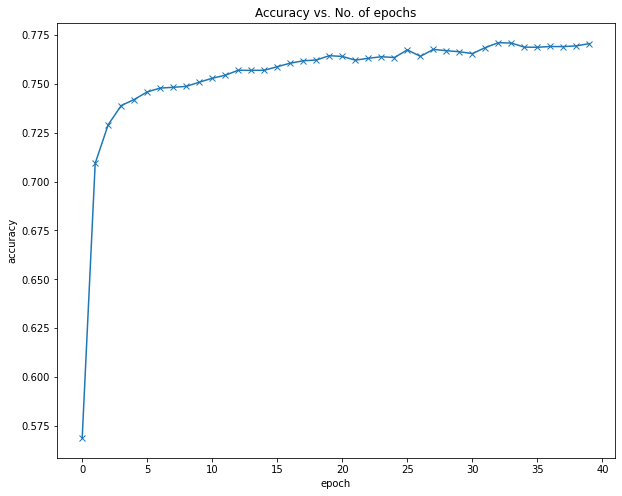

In [77]:
plt.figure(figsize=(10,8))
plt.plot(acc_trend, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

### Running our model predictions

After fitting our model, we are ready to get the predictions. First we prepare our X_test by converting it into a tensor and then running it through the model to get the predictions. 


In [78]:
X_test_sc = torch.tensor(X_test_sc).float()

In [79]:
predicts = model(X_test_sc)
Y_pred = torch.argmax(predicts, dim=1)
Y_pred

tensor([0, 0, 0,  ..., 2, 0, 2])

In [80]:
Y_pred = pd.Series(Y_pred)
Y_pred.head(10)

0    0
1    0
2    0
3    2
4    0
5    0
6    2
7    2
8    2
9    0
dtype: int64

We have finished generating our predictions. We can now get ready for submission.

In [81]:
pred_Id = X_test['id']
submit = pd.DataFrame(data=pred_Id, columns=['id'])
submit['status_group'] = Y_pred
submit.head()

,id,status_group
0,50785,0
1,51630,0
2,17168,0
3,45559,2
4,49871,0


In [82]:
vals_to_replace = {0:'functional', 1:'functional needs repair',
                   2:'non functional'}

submit.status_group = submit.status_group.replace(vals_to_replace)
submit.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [83]:
submit.to_csv('ann_predictions.csv', index=False)

In our submission with the first artificial neural network, we attained a score of **0.7687** using the 80 epochs and learning rate 0.01. We will next attempt to put the model through hyperparameter tuning using Ax to try and improve our model.

### Hyperparameter Tuning with Ax

Our first artificial neural network model has been completed. We now try to tune our hyperparameters using the Adaptive Experimentation Platform. 

In [84]:
# !pip install ax-platform

In [85]:
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting

The first code segment below describes how the model will be trained. In this case, the learning rate, momentum and number of epochs are set to be tuned later.

In [86]:
def train(net, parameterization, trainloader):
  optimizer = optim.SGD(net.parameters(), lr=parameterization["lr"], momentum=parameterization["momentum"])
  criterion = nn.CrossEntropyLoss()

  for epoch in range(parameterization["epochs"]):
    # model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # print(i)
      inputs, labels = data
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs,labels)

      loss.backward()
      optimizer.step() 
      # opt.zero_grad()

      running_loss += loss.item()
      if i%400 == 399:
        print('[%d, %5d] loss: %.3f'%(epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0
    # model.eval()
  return net

After which, we create an evaluation function that will check the fitting with the validation set to determine the accuracy of the current fit.

In [87]:
def evaluate(net, testloader):
  correct = 0
  total = 0
  with torch.no_grad():
    for data in testloader:
      xb, yb = data
      outputs = net(xb)
      _, predicted = torch.max(outputs.data, 1)
      total += yb.size(0)
      correct += (predicted==yb).sum().item()
  print("Accuracy: %d%%"%(100*correct/total))
  return 100*correct/total

In [88]:
def train_evaluate(parameterization):
  net = Net()
  net = train(net, parameterization, train_loader)
  return evaluate(net, val_loader)

After completing the model, we set the hyperparameters as shown below. As we are not sure what learning rate to use, we set it from a low figure of 1e-6 to a high value of 0.4 to cover all possible use cases. 
For momentum, we set it to value of 0 to 1.
As for the number of epochs, we set it to be a range of 20 to 50. As the accuracy seems to stabilize after 30, we do not want to overfit or underfit our model.

In [89]:
best_parameters, values, experiment, model = optimize(
    parameters=[
                {"name": "lr", "type": "range", "bounds":[1e-6, 0.4],"log_scale":True},
                {"name": "momentum", "type": "range", "bounds": [0.0,1.0]},
                {"name": "epochs", "type": "range", "bounds": [20,50]},
    ],
    evaluation_function = train_evaluate,
    objective_name = 'accuracy',
    total_trials = 40
)

[INFO 11-11 03:46:39] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 11-11 03:46:39] ax.service.managed_loop: Started full optimization with 40 steps.
[INFO 11-11 03:46:39] ax.service.managed_loop: Running optimization trial 1...


[1,   400] loss: 0.215
[2,   400] loss: 0.214
[3,   400] loss: 0.214
[4,   400] loss: 0.213
[5,   400] loss: 0.212
[6,   400] loss: 0.212
[7,   400] loss: 0.211
[8,   400] loss: 0.211
[9,   400] loss: 0.210
[10,   400] loss: 0.209
[11,   400] loss: 0.209
[12,   400] loss: 0.208
[13,   400] loss: 0.208
[14,   400] loss: 0.207
[15,   400] loss: 0.207
[16,   400] loss: 0.206
[17,   400] loss: 0.206
[18,   400] loss: 0.205
[19,   400] loss: 0.205
[20,   400] loss: 0.205
[21,   400] loss: 0.204
[22,   400] loss: 0.204
[23,   400] loss: 0.203
[24,   400] loss: 0.203
[25,   400] loss: 0.203
[26,   400] loss: 0.202
[27,   400] loss: 0.202
[28,   400] loss: 0.201
[29,   400] loss: 0.201
[30,   400] loss: 0.201


[INFO 11-11 03:47:10] ax.service.managed_loop: Running optimization trial 2...


Accuracy: 53%
[1,   400] loss: 0.191
[2,   400] loss: 0.153
[3,   400] loss: 0.136
[4,   400] loss: 0.132
[5,   400] loss: 0.130
[6,   400] loss: 0.128
[7,   400] loss: 0.127
[8,   400] loss: 0.126
[9,   400] loss: 0.125
[10,   400] loss: 0.123
[11,   400] loss: 0.123
[12,   400] loss: 0.122
[13,   400] loss: 0.121
[14,   400] loss: 0.120
[15,   400] loss: 0.119
[16,   400] loss: 0.119
[17,   400] loss: 0.119
[18,   400] loss: 0.117
[19,   400] loss: 0.117
[20,   400] loss: 0.117
[21,   400] loss: 0.116
[22,   400] loss: 0.115
[23,   400] loss: 0.115
[24,   400] loss: 0.114
[25,   400] loss: 0.114
[26,   400] loss: 0.114
[27,   400] loss: 0.113
[28,   400] loss: 0.113
[29,   400] loss: 0.113


[INFO 11-11 03:47:39] ax.service.managed_loop: Running optimization trial 3...


Accuracy: 76%
[1,   400] loss: 0.133
[2,   400] loss: 0.121
[3,   400] loss: 0.117
[4,   400] loss: 0.115
[5,   400] loss: 0.114
[6,   400] loss: 0.112
[7,   400] loss: 0.112
[8,   400] loss: 0.111
[9,   400] loss: 0.110
[10,   400] loss: 0.109
[11,   400] loss: 0.109
[12,   400] loss: 0.108
[13,   400] loss: 0.107
[14,   400] loss: 0.108
[15,   400] loss: 0.107
[16,   400] loss: 0.107
[17,   400] loss: 0.106
[18,   400] loss: 0.106
[19,   400] loss: 0.105
[20,   400] loss: 0.105
[21,   400] loss: 0.105


[INFO 11-11 03:48:00] ax.service.managed_loop: Running optimization trial 4...


Accuracy: 75%
[1,   400] loss: 0.141


KeyboardInterrupt: ignored

In [90]:
best_p = best_parameters
best_p

NameError: ignored

In [ ]:
values

In [ ]:
render(plot_contour(model=model, param_x='lr', param_y='momentum', metric_name='accuracy'))

In [ ]:
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])
best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot)

###Model Fitting

Now we will prepare to fit a new model using the tuned hyperparameters found above.



In [ ]:
lr = best_p['lr']
momentum = best_p['momentum']

def get_model():
  model = Net()
  return model, optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [ ]:
model, opt = get_model()
acc_trend = []

def fit():
  for epoch in range(best_p['epochs']):
    model.train()
    for xb, yb in train_loader:
      pred = model(xb)
      loss = loss_func(pred,yb)

      loss.backward()
      opt.step() 
      opt.zero_grad()

    model.eval()
    with torch.no_grad():
      valid_loss = sum(loss_func(model(xb), yb) for xb,yb in val_loader)/len(val_loader)
      valid_acc = sum(accuracy(model(xb),yb) for xb,yb in val_loader)/len(val_loader)
      acc_trend.append(valid_acc)
    print(epoch, valid_loss, valid_acc)

print(loss_func(model(xb), yb))
fit()
print(loss_func(model(xb), yb))

In [ ]:
predicts = model(X_test_sc)
Y_pred = torch.argmax(predicts, dim=1)
Y_pred

In [ ]:
Y_pred = pd.Series(Y_pred)
Y_pred.head(10)

In [ ]:
pred_Id = X_test['id']
submit = pd.DataFrame(data=pred_Id, columns=['id'])
submit['status_group'] = Y_pred
submit.head()

In [ ]:
vals_to_replace = {0:'functional', 1:'functional needs repair',
                   2:'non functional'}

submit.status_group = submit.status_group.replace(vals_to_replace)
submit.head()

In [ ]:
submit.to_csv('ann_tuned__predictions.csv', index=False)

The finalised model has the following parameters:
*   Input layer of 89 features, scaled
*   2 Hidden layers (89 x 30) and (30 x 20) computed using reLu
*   1 output layer computed using softmax
*   Batch size: 100
*   No. Epochs: 44
*   Learning rate: 0.036359772988197446
*   Momentum: 0.8476386666297913
*   Loss function: Cross Entropy loss

Submitting our model into the competition page, we got a score of **0.7756**. 